# Import

In [1]:
import os
from datetime import datetime
from itertools import chain

import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

import nibabel as nib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DataLoader

In [4]:
class MyDataset(Dataset):
    def __init__(self, test_size=0.2, test=False):
        
        data_files = glob('../../brainmask_nii/*.nii')
        data_files.sort()
        
        test_num = int(test_size * len(data_files))
        train_num = len(data_files) - test_num
        shuffled_index = np.random.permutation(len(data_files))
        
        train_fname = [data_files[i] for i in shuffled_index[:train_num]]
        test_fname  = [data_files[i] for i in shuffled_index[-test_num:]]
        
        label_file = pd.read_csv('../rsc/age_ixi_and_oasis.csv', index_col=0)
        
        if test:
            self.data_files = [data_files[i] for i in shuffled_index[-test_num:]]
            self.label_file = label_file.age_zscored.values[shuffled_index[-test_num:]]
            
        else:
            self.data_files = [data_files[i] for i in shuffled_index[:train_num]]
            self.label_file = label_file.age_zscored.values[shuffled_index[:train_num]]

    def __getitem__(self, idx):
        #print(idx)
        x = torch.tensor(nib.load(self.data_files[idx]).get_fdata())[None, :, :].float() / 255
        y = torch.tensor(self.label_file[idx]).float()
        return x, y

    def __len__(self):
        return len(self.data_files)

train_dset = MyDataset()
test_dset  = MyDataset(test=True)

train_loader = DataLoader(train_dset, batch_size=8)
test_loader = DataLoader(test_dset, batch_size=8)

# 3D Convolution Model

## Modeling

In [8]:
class Conv3d(nn.Module):
    
    def __init__(self):
        super(Conv3d, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv3d(1, 8, 3, 3),
            nn.BatchNorm3d(8),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv3d(8, 16, 3, 3),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
                
        self.layer3 = nn.Sequential(
            nn.Conv3d(16, 32, 3, 3),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.MaxPool3d(kernel_size=2, stride=2)
        )
        
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.reshape(x.size(0), -1)
        print(x.shape)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [9]:
model = Conv3d().float()
model.to(device)

Conv3d(
  (layer1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(3, 3, 3))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=128, 

## Debug

In [10]:
with torch.no_grad():
    for i, (x, y)in enumerate(test_loader):
        if i < 1:
            x = x.to(device)
            y = y.to(device)
            print(model.forward(x), y)
        else:
            break

torch.Size([8, 32])


RuntimeError: mat1 dim 1 must match mat2 dim 0

## Passing through Model

In [10]:
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
loss_fn = nn.MSELoss()

In [12]:
epochs = range(150)

trn_losses, tst_losses = [], []

for e in epochs:
    
    trn_bth_loss = 0
    model.train()
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        y_pred = model.forward(x).to(device)
        
        loss = loss_fn(y_pred, y)
        del x, y, y_pred

        loss.backward()
        optimizer.step()

        trn_bth_loss += loss.item()
        
        if not i % 20:
            print(f'{i:<4}th Batch. Loss: {loss.item():.3f}')

    torch.cuda.empty_cache()
    trn_losses.append(trn_bth_loss / len(train_loader))
        
        
    tst_bth_loss = 0
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device), y.to(device)

            y_pred = model.forward(x).to(device)
            loss = loss_fn(y_pred, y)
            del x, y, y_pred

            tst_bth_loss += loss.item()

    tst_losses.append(tst_bth_loss / len(test_loader))
    torch.cuda.empty_cache()
    
    # Print
    print(f'EPOCHS {e} | TRAIN :: [LOSS] {trn_losses[-1]:.3f} | VALID :: [LOSS] {tst_losses[-1]:.3f}')

C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0   th Batch. Loss: 0.385
20  th Batch. Loss: 0.950
40  th Batch. Loss: 1.195
60  th Batch. Loss: 0.392
80  th Batch. Loss: 1.083
100 th Batch. Loss: 1.024


C:\Users\pha\anaconda3\envs\1pha\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCHS 0 | TRAIN :: [LOSS] 1.093 | VALID :: [LOSS] 1.102
0   th Batch. Loss: 0.655
20  th Batch. Loss: 1.093
40  th Batch. Loss: 1.176
60  th Batch. Loss: 0.367
80  th Batch. Loss: 1.211
100 th Batch. Loss: 0.887
EPOCHS 1 | TRAIN :: [LOSS] 1.021 | VALID :: [LOSS] 1.139
0   th Batch. Loss: 0.776
20  th Batch. Loss: 0.994
40  th Batch. Loss: 1.223
60  th Batch. Loss: 0.353
80  th Batch. Loss: 1.088
100 th Batch. Loss: 0.632
EPOCHS 2 | TRAIN :: [LOSS] 1.021 | VALID :: [LOSS] 1.080
0   th Batch. Loss: 0.504
20  th Batch. Loss: 0.935
40  th Batch. Loss: 1.147
60  th Batch. Loss: 0.382
80  th Batch. Loss: 0.995
100 th Batch. Loss: 0.631
EPOCHS 3 | TRAIN :: [LOSS] 1.001 | VALID :: [LOSS] 1.060
0   th Batch. Loss: 0.402
20  th Batch. Loss: 0.970
40  th Batch. Loss: 1.148
60  th Batch. Loss: 0.394
80  th Batch. Loss: 0.980
100 th Batch. Loss: 0.642
EPOCHS 4 | TRAIN :: [LOSS] 0.992 | VALID :: [LOSS] 1.058
0   th Batch. Loss: 0.389
20  th Batch. Loss: 0.987
40  th Batch. Loss: 1.154
60  th Batch.

20  th Batch. Loss: 0.974
40  th Batch. Loss: 1.174
60  th Batch. Loss: 0.431
80  th Batch. Loss: 0.975
100 th Batch. Loss: 0.719
EPOCHS 39 | TRAIN :: [LOSS] 0.961 | VALID :: [LOSS] 1.063
0   th Batch. Loss: 0.399
20  th Batch. Loss: 1.007
40  th Batch. Loss: 1.163
60  th Batch. Loss: 0.427
80  th Batch. Loss: 0.974
100 th Batch. Loss: 0.675
EPOCHS 40 | TRAIN :: [LOSS] 0.962 | VALID :: [LOSS] 1.069
0   th Batch. Loss: 0.369
20  th Batch. Loss: 0.976
40  th Batch. Loss: 1.164
60  th Batch. Loss: 0.411
80  th Batch. Loss: 0.987
100 th Batch. Loss: 0.687
EPOCHS 41 | TRAIN :: [LOSS] 0.956 | VALID :: [LOSS] 1.076
0   th Batch. Loss: 0.404
20  th Batch. Loss: 0.986
40  th Batch. Loss: 1.163
60  th Batch. Loss: 0.401
80  th Batch. Loss: 0.981
100 th Batch. Loss: 0.698
EPOCHS 42 | TRAIN :: [LOSS] 0.957 | VALID :: [LOSS] 1.151
0   th Batch. Loss: 0.492
20  th Batch. Loss: 0.984
40  th Batch. Loss: 1.177
60  th Batch. Loss: 0.368
80  th Batch. Loss: 0.978
100 th Batch. Loss: 0.672
EPOCHS 43 | TR

80  th Batch. Loss: 0.993
100 th Batch. Loss: 0.669
EPOCHS 77 | TRAIN :: [LOSS] 0.898 | VALID :: [LOSS] 1.105
0   th Batch. Loss: 0.329
20  th Batch. Loss: 0.902
40  th Batch. Loss: 1.090
60  th Batch. Loss: 0.333
80  th Batch. Loss: 1.003
100 th Batch. Loss: 0.632
EPOCHS 78 | TRAIN :: [LOSS] 0.891 | VALID :: [LOSS] 1.103
0   th Batch. Loss: 0.296
20  th Batch. Loss: 0.936
40  th Batch. Loss: 1.093
60  th Batch. Loss: 0.380
80  th Batch. Loss: 1.036
100 th Batch. Loss: 0.612
EPOCHS 79 | TRAIN :: [LOSS] 0.894 | VALID :: [LOSS] 1.112
0   th Batch. Loss: 0.321
20  th Batch. Loss: 0.922
40  th Batch. Loss: 1.116
60  th Batch. Loss: 0.338
80  th Batch. Loss: 1.005
100 th Batch. Loss: 0.616
EPOCHS 80 | TRAIN :: [LOSS] 0.895 | VALID :: [LOSS] 1.117
0   th Batch. Loss: 0.308
20  th Batch. Loss: 0.948
40  th Batch. Loss: 1.090
60  th Batch. Loss: 0.347
80  th Batch. Loss: 0.990
100 th Batch. Loss: 0.666
EPOCHS 81 | TRAIN :: [LOSS] 0.890 | VALID :: [LOSS] 1.120
0   th Batch. Loss: 0.335
20  th B

EPOCHS 115 | TRAIN :: [LOSS] 0.870 | VALID :: [LOSS] 1.103
0   th Batch. Loss: 0.301
20  th Batch. Loss: 0.915
40  th Batch. Loss: 1.087
60  th Batch. Loss: 0.315
80  th Batch. Loss: 0.984
100 th Batch. Loss: 0.699
EPOCHS 116 | TRAIN :: [LOSS] 0.870 | VALID :: [LOSS] 1.109
0   th Batch. Loss: 0.305
20  th Batch. Loss: 0.916
40  th Batch. Loss: 1.076
60  th Batch. Loss: 0.324
80  th Batch. Loss: 0.979
100 th Batch. Loss: 0.618
EPOCHS 117 | TRAIN :: [LOSS] 0.871 | VALID :: [LOSS] 1.105
0   th Batch. Loss: 0.296
20  th Batch. Loss: 0.908
40  th Batch. Loss: 1.088
60  th Batch. Loss: 0.327
80  th Batch. Loss: 0.975
100 th Batch. Loss: 0.619
EPOCHS 118 | TRAIN :: [LOSS] 0.867 | VALID :: [LOSS] 1.115
0   th Batch. Loss: 0.302
20  th Batch. Loss: 0.908
40  th Batch. Loss: 1.091
60  th Batch. Loss: 0.315
80  th Batch. Loss: 0.991
100 th Batch. Loss: 0.646
EPOCHS 119 | TRAIN :: [LOSS] 0.871 | VALID :: [LOSS] 1.102
0   th Batch. Loss: 0.297
20  th Batch. Loss: 0.911
40  th Batch. Loss: 1.083
60 

# Plot Result

### Loss

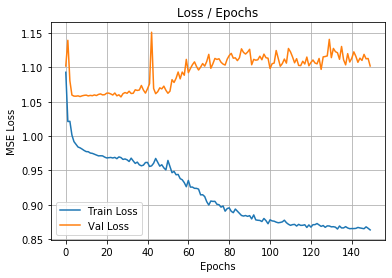

In [22]:
plt.plot(trn_losses)
plt.plot(tst_losses)
plt.legend(['Train Loss', 'Val Loss'])
plt.title('Loss / Epochs')
plt.xlabel('Epochs')
#plt.xticks(np.arange(0, 20, step=2), [x for x in np.arange(0, 20, step=2)])
plt.ylabel('MSE Loss')
plt.grid()
plt.show()

### Regression Accuracy

In [23]:
def plot_result(trues, preds, title='Train', fname=None):
    preds = np.array(list(chain(*preds)))
    trues = np.array(list(chain(*trues)))
    
    cut = max(max(abs(preds)), max(abs(trues)))
    cuts = [-cut, cut]
              
    plt.figure(figsize=(14, 14))
    plt.scatter(preds, trues)
    plt.xlim(*cuts)
    plt.ylim(*cuts)
    plt.xlabel('Prediction')
    plt.ylabel('True')
    plt.title(f'{title} Dataset Prediction')
    plt.grid()
    domain = np.linspace(*cuts, 100)
    plt.plot(domain, domain, c='black')
    if fname:
        plt.savefig(f'./result/{fname}_{title}.png')
    plt.show()

In [24]:
fname = f'{datetime.now().strftime("%Y-%m-%d_%H%M-")}_lr{lr}'

### Train

In [17]:
model.eval()
train_true, train_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(train_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        train_pred.append(y_pred.to('cpu'))
        train_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

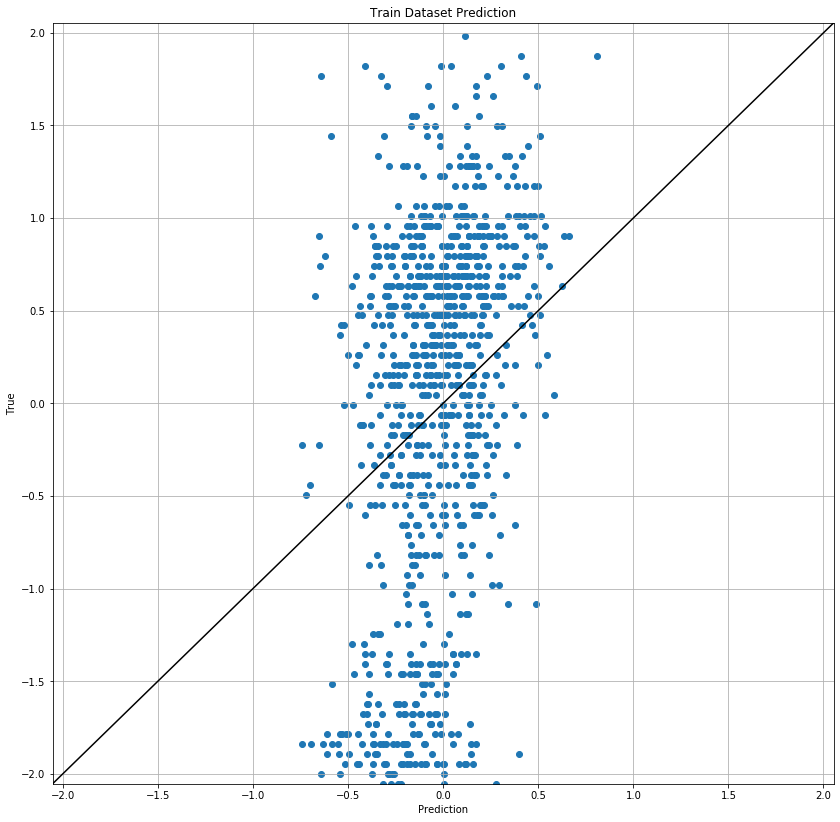

In [25]:
plot_result(train_true, train_pred, fname=fname)

### Test

In [19]:
model.eval()
test_true, test_pred = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(tqdm(test_loader)):

        x, y = x.to(device), y.to(device)
        y_pred = model.forward(x).to(device)

        test_pred.append(y_pred.to('cpu'))
        test_true.append(y.to('cpu'))

        del x, y, y_pred
        torch.cuda.empty_cache()

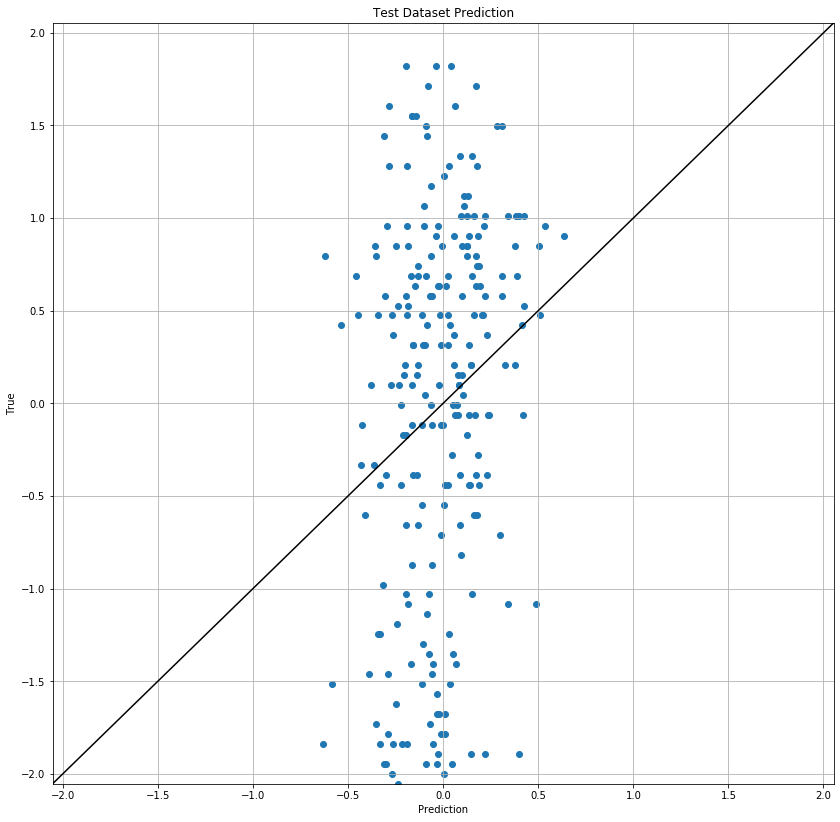

In [26]:
plot_result(test_true, test_pred, title='Test', fname=fname)

## Save Model

In [21]:
torch.save(model, f"./models/{fname}_model.pth")